# SAGAN (Self-Attention Generative Adversarial Networks)
https://arxiv.org/pdf/1805.08318

In [1]:
from google.colab import drive
from pathlib import Path

drive.mount('/content/drive')
DRIVE_ROOT = Path('/content/drive/MyDrive')

DATA_ROOT= Path('./data/')
MODEL_ROOT = DRIVE_ROOT / 'weights'

!mkdir -p {DATA_ROOT}
!mkdir -p {MODEL_ROOT}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%pip install -q matplotlib
%pip install -q torchviz torchinfo
%pip install -q tqdm

In [3]:
from IPython.display import display

import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from tqdm.notebook import tqdm

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torchinfo import summary
from torchvision import datasets, models, ops, transforms

%matplotlib inline
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = (3, 3)
plt.rcParams['axes.grid'] = True
np.set_printoptions(suppress=True, precision=4)

def get_device():
    '''Get device (CPU or GPU).'''
    return torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Network Models
### Self-Attention
Self-Attention is a mechanism that allows a model to capture the relationships of each part to every other part, enable to consider connections between parts that are far apart and to understand the overall structure or semantics in a global context.

The computation proceeds as follows:

1. Linearly project an input feature map `x` into three components: Query (`Q`), Key (`K`), and Value (`V`). These projections are typically implemented using `1 × 1` convolutions or linear layers.  
   $$
   Q = f_Q(x), \quad K = f_K(x), \quad V = f_V(x)
   $$

2. Compute attention scores using `Q` and `K` and normalize them by softmax:  
   $$
   \text{score} = Q \cdot K^T \\
   \text{attention} = \text{softmax}(\text{score})
   $$

3. Apply the attention weights to `V`:  
   $$
   O = \text{attention} \cdot V
   $$

4. Finally, add the output to the original input:  
   $$
   y = x + \gamma \cdot O
   $$

In [4]:
class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super(SelfAttention, self).__init__()
        self.softmax = nn.Softmax(dim=-2)

        # Pointwise convolution layers to generate Q, K and V.
        self.query_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)

        # A learnable scaling factor 'gamma' used in `y = x + gamma * o`.
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        B, C, H, W = x.size()
        N = H * W

        # Compute an attention map using Q and K.
        query = self.query_conv(x).view(B, -1, N).permute(0, 2, 1)  # Size([B, N, C])
        key = self.key_conv(x).view(B, -1, N)                       # Size([B, C, N])
        S = torch.bmm(query, key)                                   # Size([B, N, N])

        attention_map_T = self.softmax(S)
        attention_map = attention_map_T.permute(0, 2, 1)            # Size([B, N, N])

        # Multiply the value by the attention map.
        value = self.value_conv(x).view(B, -1, N)                   # Size([B, C, N])
        o = torch.bmm(value, attention_map.permute(0, 2, 1))        # Size([B, C, N])

        # output = x + gamma * o
        o = o.view(B, C, H, W)
        output = x + self.gamma * o
        return output, attention_map


### Generator


In [5]:
class Generator(nn.Module):
    def __init__(self, z_dim=20, image_size=64):
        super(Generator, self).__init__()

        self.layer1 = nn.Sequential(
            nn.utils.spectral_norm(nn.ConvTranspose2d(
                z_dim, image_size * 8, kernel_size=4, stride=1)),
            nn.BatchNorm2d(image_size * 8),
            nn.ReLU(inplace=True)
        )

        self.layer2 = nn.Sequential(
            nn.utils.spectral_norm(nn.ConvTranspose2d(
                image_size * 8, image_size * 4,kernel_size=4, stride=2, padding=1)),
            nn.BatchNorm2d(image_size * 4),
            nn.ReLU(inplace=True)
        )

        self.layer3 = nn.Sequential(
            nn.utils.spectral_norm(nn.ConvTranspose2d(
                image_size * 4, image_size * 2, kernel_size=4, stride=2, padding=1)),
            nn.BatchNorm2d(image_size * 2),
            nn.ReLU(inplace=True)
        )

        self.self_attention1 = SelfAttention(in_dim=image_size * 2)

        self.layer4 = nn.Sequential(
            nn.utils.spectral_norm(nn.ConvTranspose2d(
                image_size * 2, image_size, kernel_size=4, stride=2, padding=1)),
            nn.BatchNorm2d(image_size),
            nn.ReLU(inplace=True)
        )

        self.self_attention2 = SelfAttention(in_dim=image_size)

        self.last = nn.Sequential(
            nn.ConvTranspose2d(image_size, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        z = z.unsqueeze(-1).unsqueeze(-1)  # Size([N, z_dim, 1, 1])
        z = self.layer1(z)
        z = self.layer2(z)
        z = self.layer3(z)
        z, attention_map1 = self.self_attention1(z)
        z = self.layer4(z)
        z, attention_map2 = self.self_attention2(z)
        z = self.last(z)                    # Size([N, 1, image_size, image_size])
        return z, attention_map1, attention_map2

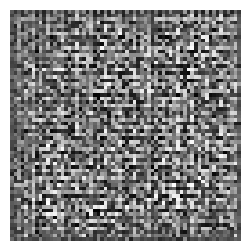

In [6]:
G = Generator(z_dim=20, image_size=8)
fake_images, _, _ = G(torch.randn(1, 20))
plt.imshow(fake_images[0][0].detach().numpy(), cmap='gray')
plt.axis('off')
plt.show()

### Discriminator
Fake images -- ( Discriminator ) --> Score [Fake: 0, Real: 1]

In [7]:
class Discriminator(nn.Module):
    def __init__(self, z_dim=20, image_size=64):
        super(Discriminator, self).__init__()

        self.layer1 = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(
                1, image_size, kernel_size=4, stride=2, padding=1)),
            nn.LeakyReLU(0.1, inplace=True)
        )

        self.layer2 = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(
                image_size, image_size*2, kernel_size=4, stride=2, padding=1)),
            nn.LeakyReLU(0.1, inplace=True)
        )

        self.layer3 = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(
                image_size*2, image_size*4, kernel_size=4, stride=2, padding=1)),
            nn.LeakyReLU(0.1, inplace=True)
        )

        self.self_attention1 = SelfAttention(in_dim=image_size*4)

        self.layer4 = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(
                image_size*4, image_size*8, kernel_size=4, stride=2, padding=1)),
            nn.LeakyReLU(0.1, inplace=True)
        )

        self.self_attention2 = SelfAttention(in_dim=image_size*8)
        self.last = nn.Conv2d(image_size*8, 1, kernel_size=4, stride=1)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x, attention_map1 = self.self_attention1(x)
        x = self.layer4(x)
        x, attention_map2 = self.self_attention2(x)
        x = self.last(x)
        return x, attention_map1, attention_map2

In [8]:
G = Generator(z_dim=20, image_size=8)
D = Discriminator(z_dim=20, image_size=8)

fake_images, _, _ = G(torch.randn(1, 20))
d_out, _, _ = D(fake_images)

print(nn.Sigmoid()(d_out))

tensor([[[[0.5153]]]], grad_fn=<SigmoidBackward0>)


In [9]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


def build_GAN(z_dim=20, image_size=64):
    G = Generator(z_dim=z_dim, image_size=image_size).apply(weights_init)
    D = Discriminator(z_dim=z_dim, image_size=image_size).apply(weights_init)
    return G, D

G, D = build_GAN(z_dim=20, image_size=64)
summary(G, [1, 20]), summary(D, [1, 1, 64, 64])

(==========================================================================================
 Layer (type:depth-idx)                   Output Shape              Param #
 Generator                                [1, 1, 64, 64]            --
 ├─Sequential: 1-1                        [1, 512, 4, 4]            --
 │    └─ConvTranspose2d: 2-1              [1, 512, 4, 4]            164,352
 │    └─BatchNorm2d: 2-2                  [1, 512, 4, 4]            1,024
 │    └─ReLU: 2-3                         [1, 512, 4, 4]            --
 ├─Sequential: 1-2                        [1, 256, 8, 8]            --
 │    └─ConvTranspose2d: 2-4              [1, 256, 8, 8]            2,097,408
 │    └─BatchNorm2d: 2-5                  [1, 256, 8, 8]            512
 │    └─ReLU: 2-6                         [1, 256, 8, 8]            --
 ├─Sequential: 1-3                        [1, 128, 16, 16]          --
 │    └─ConvTranspose2d: 2-7              [1, 128, 16, 16]          524,416
 │    └─BatchNorm2d: 2-8      

## Loss Function
Same loss functions are used as DCGAN.

## Dataset, Dataloader, Transformer

In [10]:
class ImageTransform():
    def __init__(self, mean, std):
        self.transform = transforms.Compose([
            transforms.Resize(64),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

    def __call__(self, image):
        return self.transform(image)

In [11]:
class TinyMnistDataset(Dataset):
    def __init__(self, root, train, keys, transform=None, download=True):
        self.dataset = datasets.MNIST(root=root, train=train, download=download)
        self.transform = transform

        self.indices = []
        for key in keys:
            key_indices = np.where(np.array(self.dataset.targets) == key)[0]
            self.indices += list(key_indices[:200])

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        image, _ = self.dataset[self.indices[idx]]
        if self.transform:
            image = self.transform(image)
        return image

In [12]:
MEAN = (0.5,)
STD = (0.5,)
batch_size = 64

train_dataset = TinyMnistDataset(
    root=DATA_ROOT, train=True, keys=[7, 8], transform=ImageTransform(MEAN, STD))

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

## Train, Run inference


In [13]:
def train(G, D,criterion, g_optimizer, d_optimizer, data_loader, device):
    G.train()
    D.train()

    total_g_loss = 0
    total_d_loss = 0
    for images in data_loader:
        images = images.to(device)
        batch_size = images.shape[0]

        # -----------------------
        # 1. Train Discriminator
        # -----------------------
        # Generate realness scores from real images.
        d_out_real, _, _ = D(images)

        # Generate realness scores from fake images.
        input_z = torch.randn(batch_size, z_dim).to(device)
        fake_images, _, _ = G(input_z)
        d_out_fake, _, _ = D(fake_images)

        # Prepare labels.
        label_real = torch.full((batch_size,), 1, dtype=torch.float).to(device)
        label_fake = torch.full((batch_size,), 0, dtype=torch.float).to(device)

        # Calculate the loss.
        d_loss_real = criterion(d_out_real.view(-1), label_real)
        d_loss_fake = criterion(d_out_fake.view(-1), label_fake)
        d_loss = d_loss_real + d_loss_fake

        # Backpropagate the loss and update the discriminator.
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # -----------------------
        # 2. Train Generator
        # -----------------------
        # Generate fake images from random noise.
        input_z = torch.randn(batch_size, z_dim).to(device)
        fake_images, _, _ = G(input_z)
        d_out_fake, _, _ = D(fake_images)

        # Calculate the loss (This provides high loss when the discriminator see through fake images.)
        g_loss = criterion(d_out_fake.view(-1), label_real)

        # Backpropagate the loss and update the discriminator.
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        total_g_loss += g_loss.item()
        total_d_loss += d_loss.item()

    return total_g_loss / len(data_loader), total_d_loss / len(data_loader)


def train_GAN(G, D, criterion, g_optimizer, d_optimizer, data_loader, num_epochs):
    device = get_device()
    torch.backends.cudnn.benchmark = True

    G.to(device)
    D.to(device)
    for epoch in range(num_epochs):
        g_loss, d_loss = train(G, D, criterion, g_optimizer, d_optimizer, data_loader, device)
        print(f'Epoch [{epoch+1}/{num_epochs}], g_loss: {g_loss:.4f}, d_loss: {d_loss:.4f}')

In [14]:
num_epochs = 300
z_dim = 20
image_size = 64
g_lr, d_lr = 0.0001, 0.0004
beta1, beta2 = 0.0, 0.9

G, D = build_GAN(z_dim=z_dim, image_size=image_size)

criterion = nn.BCEWithLogitsLoss(reduction='mean')
g_optimizer = torch.optim.Adam(G.parameters(), g_lr, [beta1, beta2])
d_optimizer = torch.optim.Adam(D.parameters(), d_lr, [beta1, beta2])

train_GAN(G, D, criterion, g_optimizer, d_optimizer, train_dataloader, num_epochs)

Epoch [1/300], g_loss: 1.0692, d_loss: 0.8890
Epoch [2/300], g_loss: 0.6719, d_loss: 0.9140
Epoch [3/300], g_loss: 1.1564, d_loss: 0.7357
Epoch [4/300], g_loss: 0.9022, d_loss: 0.8540
Epoch [5/300], g_loss: 1.7105, d_loss: 0.3832
Epoch [6/300], g_loss: 3.2359, d_loss: 0.2798
Epoch [7/300], g_loss: 3.1512, d_loss: 0.4951
Epoch [8/300], g_loss: 3.1982, d_loss: 0.1441
Epoch [9/300], g_loss: 3.2044, d_loss: 0.4233
Epoch [10/300], g_loss: 3.5230, d_loss: 0.5689
Epoch [11/300], g_loss: 0.8547, d_loss: 2.3234
Epoch [12/300], g_loss: 1.7050, d_loss: 0.4794
Epoch [13/300], g_loss: 1.9622, d_loss: 0.7377
Epoch [14/300], g_loss: 2.3306, d_loss: 0.6113
Epoch [15/300], g_loss: 1.8341, d_loss: 0.7272
Epoch [16/300], g_loss: 1.6128, d_loss: 0.6627
Epoch [17/300], g_loss: 1.5594, d_loss: 1.1264
Epoch [18/300], g_loss: 1.9233, d_loss: 0.7788
Epoch [19/300], g_loss: 1.3982, d_loss: 0.8732
Epoch [20/300], g_loss: 1.4654, d_loss: 1.4262
Epoch [21/300], g_loss: 1.3315, d_loss: 0.9553
Epoch [22/300], g_loss

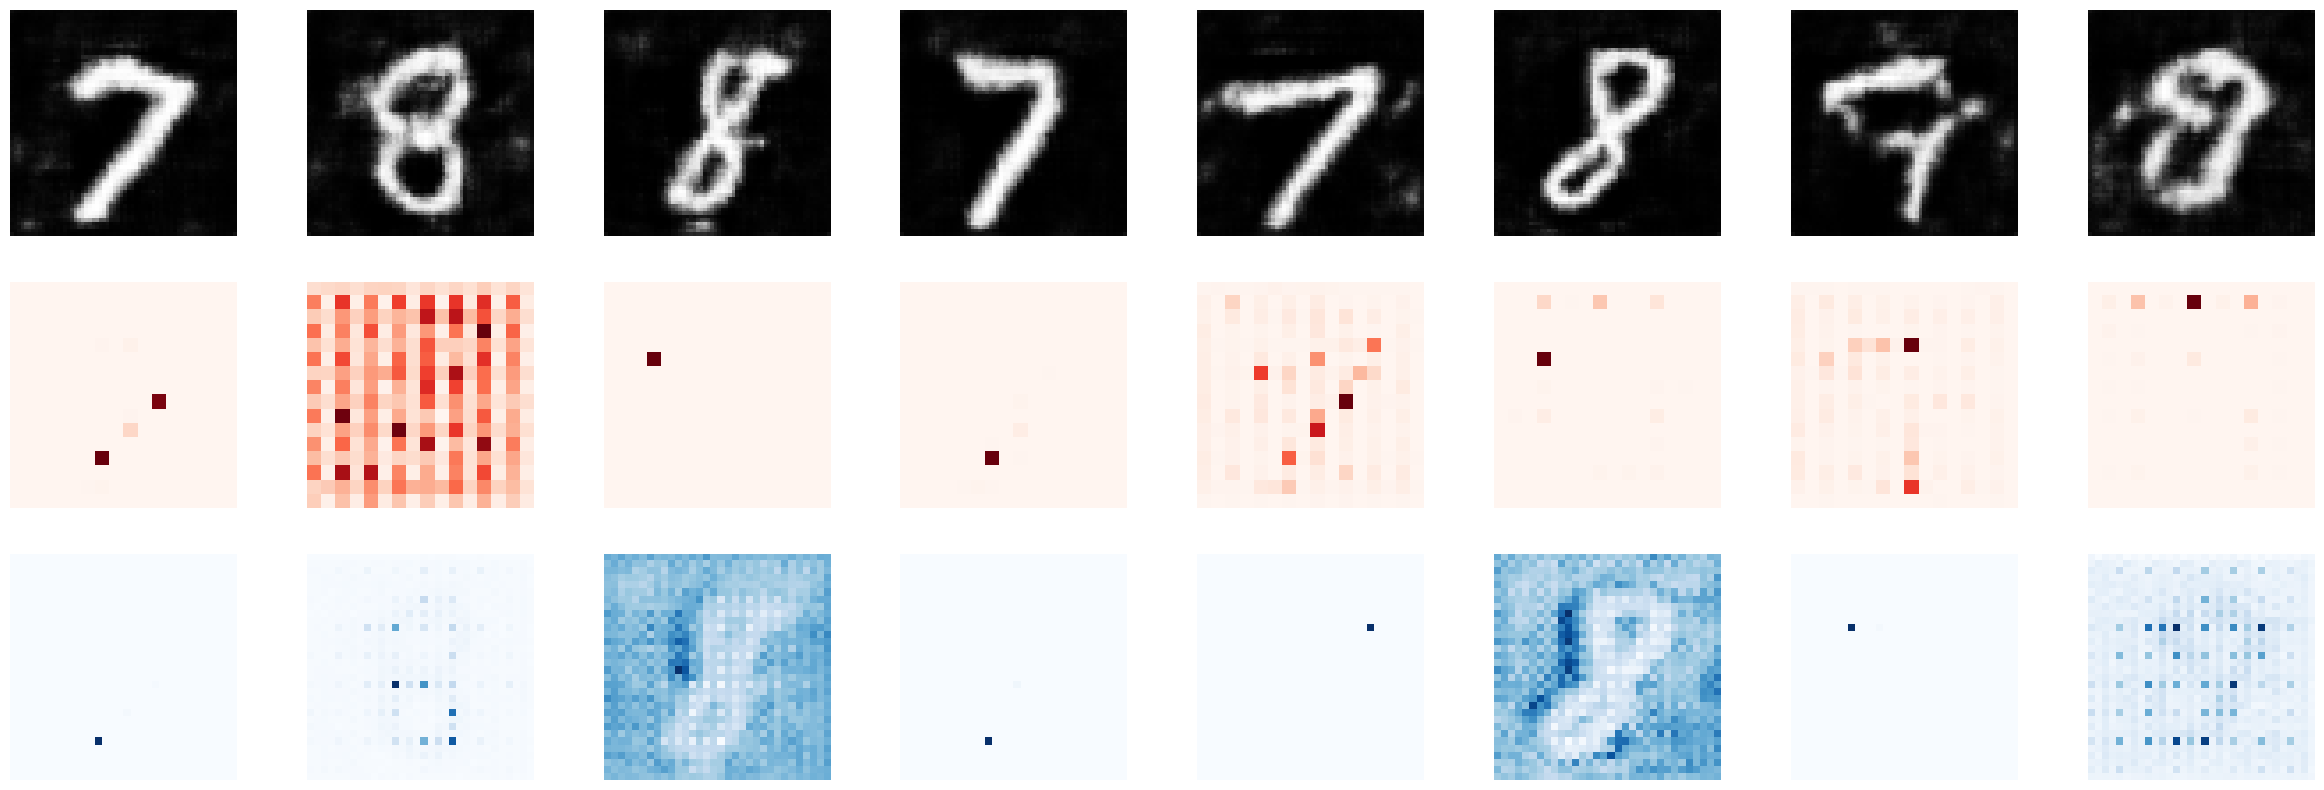

In [28]:
device = get_device()

batch_size = 8
z_dim = 20
input_z = torch.randn(batch_size, z_dim)

G.eval()
fake_images, am1, am2 = G(input_z.to(device))

fig = plt.figure(figsize=(30, 10))
for i in range(batch_size):
    plt.subplot(3, batch_size, i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')
    plt.axis('off')

    plt.subplot(3, batch_size, batch_size+i+1)
    am = am1[i].view(16, 16, 16, 16)
    am = am[7][7]
    plt.imshow(am.cpu().detach().numpy(), 'Reds')
    plt.axis('off')

    plt.subplot(3, batch_size, 2*batch_size+i+1)
    am = am2[i].view(32, 32, 32, 32)
    am = am[15][15]
    plt.imshow(am.cpu().detach().numpy(), 'Blues')
    plt.axis('off')

plt.show()